In [1]:
import pandas as pd
import numpy as np
cancer = pd.read_parquet('./Binary/data/cancer.parquet')
cancer['mean_rad_gt_mean'] = cancer['mean_radius'] > cancer['mean_radius'].mean()
cancer.head()

,has_cancer,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,mean_rad_gt_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,True
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,True
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,True
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,False
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,True


In [2]:
from sbDtypes import ColDType
from util.bootstrap import bootstrap_ci, bootstrap
from scipy.stats import pointbiserialr

In [3]:
cancer.has_cancer

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: has_cancer, Length: 569, dtype: int64

In [4]:
df = pd.read_parquet('./binary_tests.parquet')
df['missing_ints'] = df['ints'].apply(lambda x: None if ((x % 2 == 0) and (np.random.random() <= 0.5)) else x)
df['missing_chars1'] = df['chars1'].apply(lambda x: None if x == 'yes' else x)
df.head()

,ints,chars1,chars3,bools,missing_ints,missing_chars1
0,1,yes,true,True,1.0,None
1,1,yes,true,True,1.0,None
2,1,yes,true,True,1.0,None
3,1,yes,true,True,1.0,None
4,1,yes,true,True,1.0,None


In [5]:
df.to_parquet('./binary_tests.parquet', index=False)

In [6]:
df.missing_ints.value_counts(dropna=False)

missing_ints
1.0    212
0.0    180
NaN    177
Name: count, dtype: int64

In [7]:
c = ColDType(df.ints)
c.GetS(drop_na=True)

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: ints, Length: 569, dtype: int64

In [8]:
dates = pd.Series(pd.Timestamp('2020-01-01') for i in range(15000)).astype('datetime64[ns]') + pd.Series(pd.Timedelta(days=i) for i in range(15000))
dates = dates.astype(str)
dates[:5]

0    2020-01-01
1    2020-01-02
2    2020-01-03
3    2020-01-04
4    2020-01-05
dtype: object

In [9]:
d = ColDType(dates)
d.sb_dtype(return_=True)
d.format_series()
d.s_fmt

0       2020-01-01
1       2020-01-02
2       2020-01-03
3       2020-01-04
4       2020-01-05
           ...    
14995   2061-01-20
14996   2061-01-21
14997   2061-01-22
14998   2061-01-23
14999   2061-01-24
Length: 15000, dtype: datetime64[ns]

In [10]:
dates_w_missing = dates.copy()

# randomly drop 30% of the dates
dates_w_missing = dates_w_missing.apply(lambda x: None if np.random.random() <= 0.3 else x)
dates_w_missing

0        2020-01-01
1        2020-01-02
2        2020-01-03
3        2020-01-04
4        2020-01-05
            ...    
14995    2061-01-20
14996          None
14997    2061-01-22
14998    2061-01-23
14999    2061-01-24
Length: 15000, dtype: object

In [11]:
d = ColDType(dates_w_missing)
d.sb_dtype(return_=True)
print(d.sb_dtype(return_=True))
d.format_series()
d.s_fmt

date


0       2020-01-01
1       2020-01-02
2       2020-01-03
3       2020-01-04
4       2020-01-05
           ...    
14995   2061-01-20
14996   1970-01-01
14997   2061-01-22
14998   2061-01-23
14999   2061-01-24
Length: 15000, dtype: datetime64[ns]

In [12]:
for c in df.columns.tolist():
    # if c not in ['chars2', 'chars4']:
    tempcol = ColDType(df[c])
    print(f"{c}: {tempcol.sb_dtype(return_=True)}")
    tempcol.format_series()
    print(f"\nvalue_counts:\n{tempcol.s_fmt.value_counts()}")
    assert tempcol.sb_dtype(return_=True) == 'binary', \
        f"Column {c} should be binary but is {tempcol.sb_dtype(return_=True)}"

ints: binary

value_counts:
ints
0    357
1    212
Name: count, dtype: int64
chars1: binary

value_counts:
chars1
0    357
1    212
Name: count, dtype: int64
chars3: binary

value_counts:
chars3
0    357
1    212
Name: count, dtype: int64
bools: binary

value_counts:
bools
0    357
1    212
Name: count, dtype: int64
missing_ints: binary

value_counts:
missing_ints
 1       212
 0       180
-9999    177
Name: count, dtype: int64
missing_chars1: binary

value_counts:
missing_chars1
 0       357
-9999    212
Name: count, dtype: int64


In [13]:
cancer2 = cancer.copy()
for col in cancer.columns.tolist():
    s = ColDType(cancer[col])
    cancer2[col] = s.GetSFmt()


cancer2.head()

,has_cancer,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,mean_rad_gt_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


<Axes: title={'center': 'mean_radius'}, xlabel='[has_cancer]'>

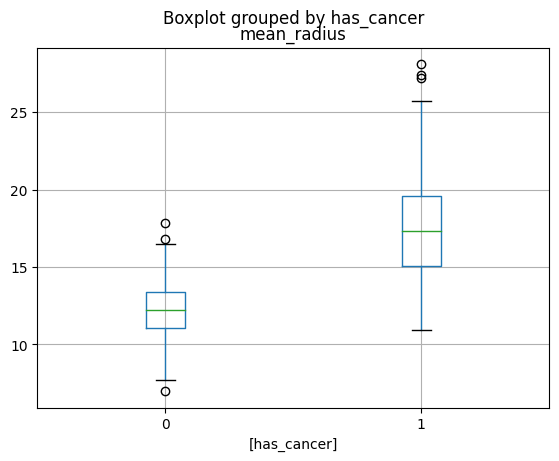

In [14]:
cancer2['has_cancer mean_radius'.split()].boxplot(by='has_cancer')

In [15]:
bootstrap?

Signature: bootstrap(x, y=None, stat_function=None, n_bootstraps=1000, subset=None)
Docstring:
Calculate bootstrap samples for a given statistic.

Parameters
----------
x : array-like
    Data to be bootstrapped.
y : array-like, optional
    Second data to be bootstrapped, depending on the statistic.
stat_function : function, optional
    Statistic to be calculated. If None, the mean is calculated.
n_bootstraps : int, optional
    Number of bootstrap samples to be generated. Default is 1000.
subset : float, optional
    Size of the subsample to be drawn from the data. If None, the size of
    the subsample is the same as the size of the data. Must be between 0
    and 1. Default is None.

Returns
-------
bootstrapped_stats : array-like

Example Usage
-------------
>>> import numpy as np
>>> from sbEDA.util.bootstrap import bootstrap
>>> x = np.random.normal(0, 1, 1000)

>>> # test that the shape of the bootstrapped means is (1000,)
>>> bootstrapped_stats = bootstrap(x=x, stat_function=

In [16]:
# bootstrap_subsample_size=0.6
# n_bootstraps=100
# x = cancer2.mean_radius.values
# x = x.reshape(x.shape[0], 1)
# y = cancer2.has_cancer
# n = len(x)
# stat_function = np.mean

# # create indicators for bootstrap subsamples
# if bootstrap_subsample_size is None:
#     bootstrap_subsample_size = 1

# # only use the portion of the data that is needed
# boot_indicators = (np.random.random((n_bootstraps, n)) < \
#                                     bootstrap_subsample_size).astype(int)

# print(f"boot_indicators.shape: {boot_indicators.shape}")
# # print(f"boot_indicators: {boot_indicators}")
# print(f"x.shape: {x.shape}")
# # print(f"x: {x}")
# # create bootstrapped samples (should return array of size (n_bootstraps, n))
# boot_x = np.matmul(boot_indicators, x)
# # if y is not None:
# #     boot_y = boot_indicators * y
# # else:
# #     boot_y = None
# # if stat_function is None:
# #     stat_function = np.mean

# boot_x.shape

<Axes: ylabel='Density'>

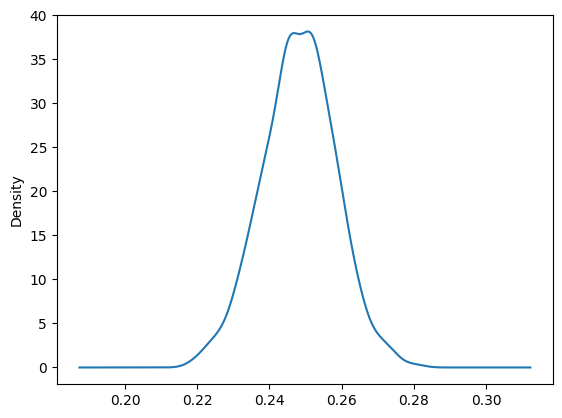

In [17]:
from util.bootstrap import bootstrap, bootstrap_ci
bootstrap(x=cancer2['mean_radius'].values,
            #  y=cancer2['has_cancer'].values,
             stat_function=lambda x: np.std(x)/np.mean(x), n_bootstraps=1000, subset=0.6).plot(kind='density')

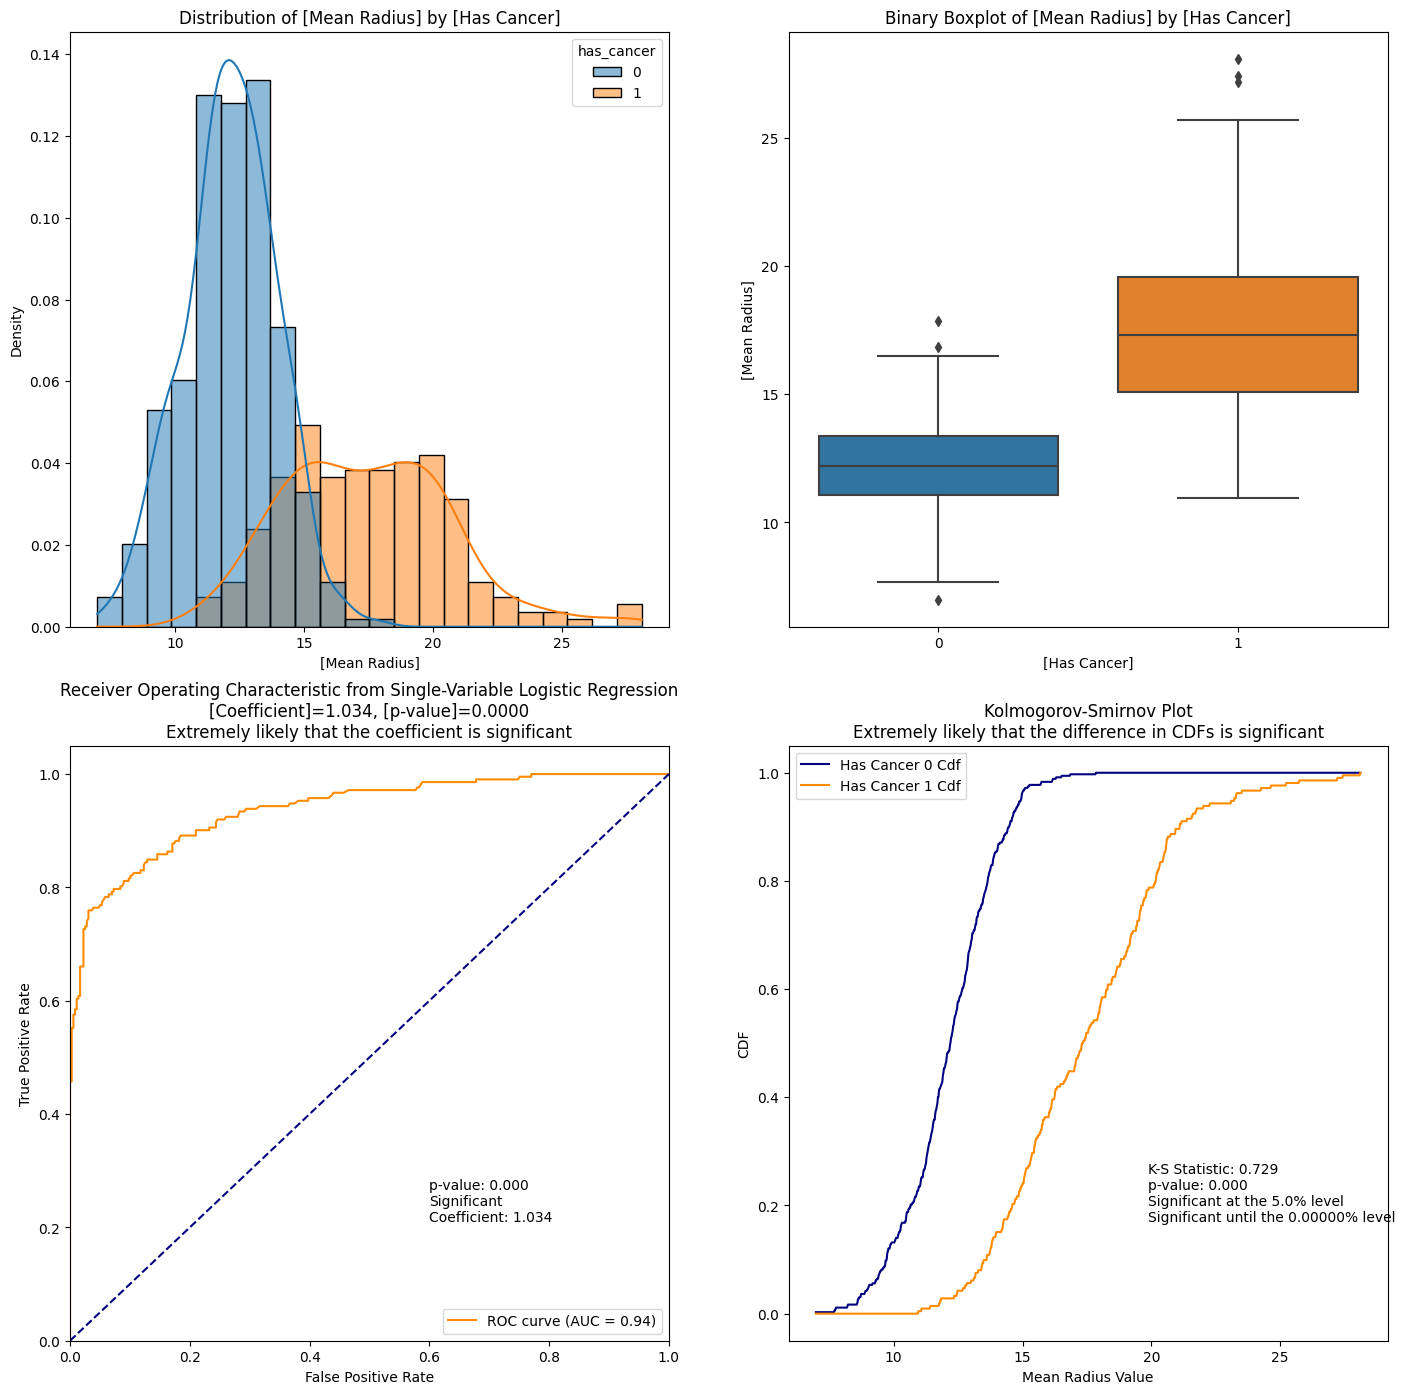

In [18]:
import matplotlib.pyplot as plt
from Binary.plot import binary_boxplot, binary_distribution_plot, binary_roc_auc, binary_ks_plot, binary_plots
# binary_plots(cancer2, 'mean_radius', 'has_cancer')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(17, 17))
ax1 = binary_distribution_plot(cancer2['mean_radius'], cancer2['has_cancer'], ax=ax1)
ax2 = binary_boxplot(cancer2['mean_radius'], cancer2['has_cancer'], ax=ax2)
ax3 = binary_roc_auc(cancer2['mean_radius'], cancer2['has_cancer'], ax=ax3)
ax4 = binary_ks_plot(cancer2['mean_radius'], cancer2['has_cancer'], ax=ax4)

In [19]:
col = ColDType(df.missing_ints)
col

ColDType(missing_ints)

In [20]:
col.s.value_counts(dropna=False)

missing_ints
1.0    212
0.0    180
NaN    177
Name: count, dtype: int64

In [21]:
col.s.drop_duplicates().reset_index(drop=True)

0    1.0
1    0.0
2    NaN
Name: missing_ints, dtype: float64

In [22]:
col.get_unique_values() 

0    1.0
1    0.0
2    NaN
Name: missing_ints, dtype: float64

In [23]:
col.s.name

'missing_ints'

In [24]:
col.is_type_known

False

In [25]:
col.is_binary

In [26]:
col.get_unique_values()

0    1.0
1    0.0
2    NaN
Name: missing_ints, dtype: float64

In [27]:
col.sb_dtype(return_=True)

'binary'

In [28]:
col.is_binary

True

In [29]:
col.s_fmt

In [30]:
binary_map = {
            0: 0,
            1: 1,
            True: 1,
            False: 0,
            "yes": 1,
            "no": 0,
            "y": 1,
            "n": 0,
            "t": 1,
            "f": 0,
            "true": 1,
            "false": 0,
        }

col.GetS(replace_na=col.binary_na_fill).map(binary_map)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
564    1.0
565    1.0
566    1.0
567    1.0
568    NaN
Name: missing_ints, Length: 569, dtype: float64

In [31]:
col.format_binary()

In [32]:
col.s.value_counts(dropna=False)

missing_ints
1.0    212
0.0    180
NaN    177
Name: count, dtype: int64

In [33]:
col.s_fmt.value_counts(dropna=False)

missing_ints
 1       212
 0       180
-9999    177
Name: count, dtype: int64